In [ ]:
!pip install pybullet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 MB 10.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import imageio_ffmpeg
from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
from gym import spaces
import pybullet as p
import torchvision.transforms as T
from math import sqrt
from google.colab import drive
import gc

/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:440: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(


current_dir=/usr/local/lib/python3.9/dist-packages/pybullet_envs/bullet


In [ ]:
class Buffer():
  def __init__(self,Buffer_size):
    self.Buffer_size = Buffer_size
    self.states = []
    self.actions = []
    self.rewards = []
    self.next_states = []
    self.dones = []
  
  def Add_(self,state,action,reward,next_state,done):
    if len(self.states) > self.Buffer_size-1: 
      del(self.states[0])
      del(self.actions[0])
      del(self.rewards[0])
      del(self.next_states[0])
      del(self.dones[0])
    self.states.append(state)
    self.actions.append(action)
    self.rewards.append(reward)
    self.next_states.append(next_state)
    self.dones.append(done)
    return self.states, self.actions, self.rewards, self.next_states, self.dones

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class Actor(nn.Module): 
  def __init__(self,state_size,action_dim):
    super(Actor,self).__init__()

    self.state_size = (state_size[0],state_size[1])

    #Convolutional neural network
    self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
    self.bn3 = nn.BatchNorm2d(32)
   
    self.Relu = nn.ReLU()

    def conv2d_size_out(size, kernel_size = 5, stride = 2):
      return (size - (kernel_size - 1) - 1) // stride  + 1

    convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(self.state_size[0])))
    convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(self.state_size[1])))
    linear_input_size = convh * convw * 32

    self.sharedlayers = nn.Sequential(
        nn.Linear(linear_input_size,128),
        nn.ReLU())
    
    #Actor network 
    self.actor = nn.Sequential(
          nn.Linear(128,128),
          nn.ReLU(),
          nn.Linear(128,action_dim),
          nn.Tanh())
  
  def sharedforward(self,state):
    Out = self.Relu(self.bn1(self.conv1(state)))
    Out = self.Relu(self.bn2(self.conv2(Out)))
    Out = self.Relu(self.bn3(self.conv3(Out)))
    Out = self.sharedlayers(Out.view(Out.size(0), -1))
    return Out
    
  def forward(self,state):
    action = self.actor(self.sharedforward(state))
    return action 
    
  def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

In [ ]:
class Critic(nn.Module): 
  def __init__(self,state_size,action_dim):
    super(Critic,self).__init__()

    self.state_size = (state_size[0],state_size[1])

    #Convolutional neural network
    self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
    self.bn3 = nn.BatchNorm2d(32)
   
    self.Relu = nn.ReLU()

    def conv2d_size_out(size, kernel_size = 5, stride = 2):
      return (size - (kernel_size - 1) - 1) // stride  + 1

    convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(self.state_size[0])))
    convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(self.state_size[1])))
    linear_input_size = convh * convw * 32

    self.sharedlayers = nn.Sequential(
        nn.Linear(linear_input_size,128),
        nn.ReLU())
    
    #Critic network 
    self.critic_action = nn.Sequential(
        nn.Linear(action_dim,128),
        nn.ReLU())
    
    self.critic_state = nn.Sequential(
        nn.Linear(128,128),
        nn.ReLU())
    
    self.critic = nn.Sequential(
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,1),
        nn.ReLU())
    
  def sharedforward(self,state):
    Out = self.Relu(self.bn1(self.conv1(state)))
    Out = self.Relu(self.bn2(self.conv2(Out)))
    Out = self.Relu(self.bn3(self.conv3(Out)))
    Out = self.sharedlayers(Out.view(Out.size(0), -1))
    return Out
    
  def forward(self,state,action):
    state_critic = self.critic_state(self.sharedforward(state))
    action_critic = self.critic_action(action)
    value = self.critic(torch.cat((state_critic, action_critic), dim=1)) 
    return value
    
  def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

In [ ]:
class DDPG():
  def __init__(self,state_size,action_dim,Actor_learning_rate,Critic_learning_rate,discount_factor,buffer_size):
    self.discount_factor = discount_factor
    self.Actor_learning_rate = Actor_learning_rate
    self.Critic_learning_rate = Critic_learning_rate
    self.state_size = state_size 
    self.action_dim = action_dim
    self.ActorTarget = Actor(self.state_size,self.action_dim)
    self.Actor = Actor(self.state_size,self.action_dim)
    self.CriticTarget = Critic(self.state_size,self.action_dim)
    self.Critic = Critic(self.state_size,self.action_dim)
    self.Buffer = Buffer(buffer_size)
    self.MSE = nn.MSELoss()
    self.actor_optimizer = torch.optim.Adam(self.Actor.parameters(),lr = self.Actor_learning_rate)
    self.critic_optimizer = torch.optim.Adam(self.Critic.parameters(),lr = self.Critic_learning_rate)
  
  def ClearBuffer(self):
     self.Buffer.states = []
     self.Buffer.actions = []
     self.Buffer.rewards = []
     self.Buffer.next_states = []
     self.Buffer.dones = []


  #Ornstein-Uhlenbeck Noise
  def Noise(self,noise,noise_std,noise_decay_rate):
    MeanAttractionConstant = 0.15
    Mean = 0 
    Ts = 0.1
    noise = noise + MeanAttractionConstant*(Mean - noise)*Ts + noise_std*round(np.random.randn(),4)*sqrt(Ts)
    noise_std = noise_std*(1 - noise_decay_rate)
    return noise,noise_std

  def step(self,env,state,noise):
    action = self.Actor.forward(state)
    #Action used to learn 
    action = action + noise
    _,reward,done,_ = env.step(action[0])
    next_state = get_screen(env)
    self.Buffer.Add_(state,action,reward,next_state,done)
    return self.Buffer.states,self.Buffer.actions,self.Buffer.rewards,self.Buffer.next_states,self.Buffer.dones
  
  #Selecting shuffle of mini batch in the buffer memory
  def Mini_batch(self,states,actions,rewards,next_states,dones,Mini_Batch_Size):
    batch_states = []
    batch_actions = []
    batch_rewards = []
    batch_next_states = []
    batch_dones = []
    indxs = [i for i in range(len(rewards))]
    np.random.shuffle(indxs)
    if len(rewards) > Mini_Batch_Size :
      batch_states = [states[ind] for ind in indxs[0:Mini_Batch_Size]] 
      batch_actions = [actions[ind] for ind in indxs[0:Mini_Batch_Size]] 
      batch_rewards = [rewards[ind] for ind in indxs[0:Mini_Batch_Size]] 
      batch_next_states = [next_states[ind] for ind in indxs[0:Mini_Batch_Size]]
      batch_dones = [dones[ind] for ind in indxs[0:Mini_Batch_Size]]
    else: 
      batch_states = states
      batch_actions = actions
      batch_rewards = rewards
      batch_next_states = next_states
      batch_dones = dones
    batch_states = torch.cat(batch_states, dim=0)
    batch_actions = torch.cat(batch_actions, dim=0)
    batch_rewards = torch.tensor(np.array(batch_rewards).reshape((-1, 1)))
    batch_next_states = torch.cat(batch_next_states, dim=0)
    return batch_states,batch_actions,batch_rewards,batch_next_states,batch_dones

  def update(self,batch_states,batch_actions,batch_rewards,batch_next_states,batch_dones):
    actions_target = self.ActorTarget.forward(batch_next_states).detach()
    values_target = self.CriticTarget.forward(batch_next_states,actions_target).detach()
    #Target value 
    for i,done in enumerate(batch_dones):
      if done: 
        values_target[i] = 0 
         
    y = batch_rewards.unsqueeze(0).to(device) + self.discount_factor * values_target
    
    #Critic update
    detached_action = batch_actions.detach()
    Values_critic = self.Critic.forward(batch_states,detached_action)
    Critic_LOSS = self.MSE(y,Values_critic)  
    #update the critic newtwork
    self.critic_optimizer.zero_grad()
    Critic_LOSS.backward(retain_graph = True)
    torch.nn.utils.clip_grad_norm_(self.Critic.parameters(),1)
    self.critic_optimizer.step()
  
  
    #Actor update
    actions = self.Actor.forward(batch_states)
    Values_critic1 = self.Critic.forward(batch_states,actions)
    Actor_LOSS = -self.MSE(torch.tensor(0.0).to(device),Values_critic1)
    #update the actor network
    self.actor_optimizer.zero_grad()
    Actor_LOSS.backward(retain_graph = True)
    torch.nn.utils.clip_grad_norm_(self.Actor.parameters(),1)
    self.actor_optimizer.step()
    return Actor_LOSS, Critic_LOSS

  def update_target(self):
    self.ActorTarget.load_state_dict(self.Actor.state_dict())
    self.CriticTarget.load_state_dict(self.Critic.state_dict())

In [ ]:
#Preprocessing of images
resize = T.Compose([T.ToPILImage(),
                    T.Resize(100, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen(env):
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    #env.render(mode='human')
    screen = env._get_observation().transpose((2, 0, 1))
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)

In [ ]:
env = KukaDiverseObjectEnv(renders=False, isDiscrete=False, removeHeightHack=False,  actionRepeat=80, maxSteps = 20,numObjects = 1 )
env.cid = p.connect(p.DIRECT)
action_space = spaces.Box(low=-1, high=1, shape=(5,1))
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env.reset()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


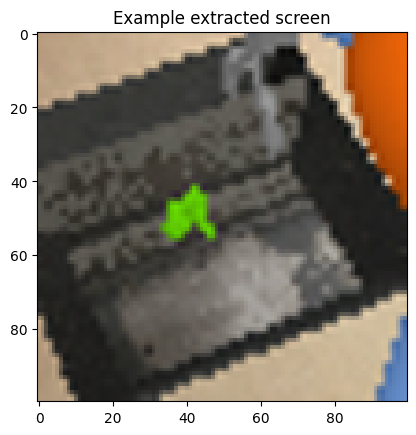

In [ ]:
#The effecor camera image 
env.reset()
plt.figure()
image = get_screen(env)
plt.imshow(image.cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [ ]:
state = get_screen(env)
state_size = (state.shape[2],state.shape[3])
action_dim = env.action_space.shape[0]

max_episodes = 1000000
max_steps = 50
saving_rate = 100
Target_updating_rate = 10
Ploting_rate = 100
MiniBatch_size = 64

noise = 0
noise_std = sqrt(0.001)
d_rewards=[]
d_ActorLOSS=[]
d_CriticLOSS=[]
AL = 0
CL = 0
s = 0
d = 0
k = 0

Policy = DDPG(state_size,action_dim,Actor_learning_rate = 0.0001,Critic_learning_rate = 0.0001,discount_factor = 0.999,buffer_size = 1e6)
Policy.Actor.init_weights()
Policy.Critic.init_weights()

if torch.cuda.is_available():
    Policy.ActorTarget.cuda()
    Policy.Actor.cuda()
    Policy.CriticTarget.cuda()
    Policy.Critic.cuda()

Policy.ClearBuffer()

for e in range(max_episodes): 
  env.reset()
  for step in range(max_steps): 
    state = get_screen(env)
    noise, noise_std = Policy.Noise(noise,noise_std,1e-4)
    states,actions,rewards,next_states,dones = Policy.step(env,state,noise)
    batch_states, batch_actions,batch_rewards, batch_next_states, batch_dones = Policy.Mini_batch(states,actions,rewards,next_states,dones,MiniBatch_size)
    Actor_Loss, Critic_Loss = Policy.update(batch_states, batch_actions.to(device),batch_rewards.to(device), batch_next_states.to(device),batch_dones)  
    Actor_Loss = Actor_Loss.detach()
    Critic_Loss = Critic_Loss.detach()
    #Update Target networks
    if (s+1)%Target_updating_rate == 0:
      Policy.update_target()
    
    #Print data
    s = s + 1 
    AL = AL + Actor_Loss
    CL = CL + Critic_Loss
    #print("episode: ",s, " reward: ",rewards[-1], " Actor Loss: ",Actor_Loss,  " Critic Loss: ",Critic_Loss) 
    if rewards[-1] == 1:
      d = d + 1

    if (e+1) % 1 == 0 and dones[-1] == 1:
      f = s - k
      print("step",f,"episode: ",e+1, " reward: ",rewards[-1], " Actor Loss: ",AL.detach().tolist()/f, " Critic Loss: ",CL.detach().tolist()/f) 
      AL = 0
      CL = 0
      k = s 

    #Saving data on GOOGLE DRIVE 
    if (e+1)%saving_rate==0 and dones[-1] == 1:
      torch.save(Policy.Actor.state_dict(), '/content/drive/MyDrive/Models/Actor.pt')
      torch.save(Policy.Critic.state_dict(), '/content/drive/MyDrive/Models/Critic.pt')
      torch.save(Policy.ActorTarget.state_dict(), '/content/drive/MyDrive/Models/ActorTarget.pt')
      torch.save(Policy.CriticTarget.state_dict(), '/content/drive/MyDrive/Models/CriticTarget.pt')
      print("===============================================SAVED======================================================= \n")
      print(" Average reward on 100 episode: ", d/saving_rate, "    number of rewards:    ",d,"\n")
      print("===========================================================================================================")
      d = 0
    if dones[-1]: 
      break

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([1, 2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

step 7 episode:  1  reward:  0  Actor Loss:  -0.05600305114473615  Critic Loss:  0.1208382078579494


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([1, 8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([9, 1])) that is different to the input size (torch.Size([1, 9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

step 7 episode:  2  reward:  1  Actor Loss:  -0.0024564367319856372  Critic Loss:  0.017377033829689026


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15, 1])) that is different to the input size (torch.Size([1, 15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([1, 16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss

step 7 episode:  3  reward:  0  Actor Loss:  -0.06508577295712062  Critic Loss:  0.03817374791417803


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([1, 22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([23, 1])) that is different to the input size (torch.Size([1, 23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss

step 7 episode:  4  reward:  0  Actor Loss:  -0.1605618851525443  Critic Loss:  0.013199353856699807


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([29, 1])) that is different to the input size (torch.Size([1, 29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([29, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([1, 30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss

step 7 episode:  5  reward:  0  Actor Loss:  -0.1387011068207877  Critic Loss:  0.008756047380822045


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([36, 1])) that is different to the input size (torch.Size([1, 36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([36, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([37, 1])) that is different to the input size (torch.Size([1, 37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss

step 7 episode:  6  reward:  0  Actor Loss:  -0.17281063965388707  Critic Loss:  0.005385714450052806


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([43, 1])) that is different to the input size (torch.Size([1, 43, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([43, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([44, 1])) that is different to the input size (torch.Size([1, 44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss

step 7 episode:  7  reward:  0  Actor Loss:  -0.20138537883758545  Critic Loss:  0.005292404443025589


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([50, 1])) that is different to the input size (torch.Size([1, 50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([50, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([51, 1])) that is different to the input size (torch.Size([1, 51, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss

step 7 episode:  8  reward:  0  Actor Loss:  -0.20093187264033727  Critic Loss:  0.004663037934473583


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([57, 1])) that is different to the input size (torch.Size([1, 57, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([57, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([58, 1])) that is different to the input size (torch.Size([1, 58, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss

step 7 episode:  9  reward:  0  Actor Loss:  -0.2074928113392421  Critic Loss:  0.0030501846756253925


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([1, 64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
step 7 episode:  19  reward:  0  Actor Loss:  -0.1047147171837943  Critic Loss:  0.0008461114817431995
step 7 episode:  20  reward:  0  Actor Loss:  -0.0896282536642892  Critic Loss:  0.000645679554768971
step 7 episode:  21  reward:  1  Actor Loss:  -0.07623440027236938  Critic Loss:  0.00329035148024559
step 7 episode:  22  reward:  0  Actor Loss:  -0.09790732179369245  Critic Loss:  0.011699786143643516
step 7 episode:  23  reward:  0  Actor Loss:  -0.08022032465253558  Critic Loss:  0.0025706041072096142
step 7 episode:  24  reward:  0  Actor Loss:  -0.10158771276473999  Critic Loss:  0.003911453166178295
step 7 episode:  25  reward:  1  Actor Loss:  -0.09547758953911918  Critic Loss:  0.0017803622675793512
step 7 episode:  26  reward:  0  Actor Loss:  -0.07752668006079537  Critic Loss:  0.005099100725991386
step 7 episode:  27  reward:  0  Actor Loss:  -0.08538434335163661  Critic Loss:  0.00509470594780